In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydicom import dcmread
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import re
from glob import glob
from wad import Dict
import cv2

In [5]:
DATA_ROOT="../UnetCosLoss/data/"
subjects=sorted(glob(DATA_ROOT+f"MRI/MRI_Label/*/",recursive=True))
subjects

['../UnetCosLoss/data/MRI/MRI_Label/1/',
 '../UnetCosLoss/data/MRI/MRI_Label/2/',
 '../UnetCosLoss/data/MRI/MRI_Label/3/',
 '../UnetCosLoss/data/MRI/MRI_Label/5/',
 '../UnetCosLoss/data/MRI/MRI_Label/8/']

In [6]:
import os
from os.path import join

In [259]:
def filt(tgt,str_list):
    return sorted([*filter(lambda x: tgt in x, str_list)])
mx=0
for sub in subjects:
    # get files
#     sub="../datas/2_Domain_Adaptation_dataset/MRI/MRI_Label/1/"
    src_dcm=sorted(glob(sub+f"**/*.dcm",recursive=True))
    src_png=sorted(glob(sub+f"**/*.png",recursive=True))
    
    # filter files, generate new file name
    src_f=Dict(img=filt("DICOM_anon",src_dcm),msk=filt("Ground",src_png))
    tmp=[m.split("/") for m in src_f.msk]
    new_dir=join(*tmp[0][:-2],"NewGT")
    os.makedirs(new_dir,exist_ok=True)
    new_fname=[join(new_dir,t[-1]) for t in tmp] ###
    # Image reading
    slices = [dcmread(d) for d in src_f.img]
    image=np.stack([s.pixel_array.astype("float") for s in slices])
    
    if image.max()>mx:
        mx=image.max()
#     image[image>5000]=0.
    
    mean=image[:,0,0].mean()
#     std=image[:,0,0].std()
    image=image-mean
    image=1-np.exp(-image*0.01)
    image=(image-image.min())/(image.max()-image.min()) ###
    
    # Mask   
    masks = np.stack([cv2.imread(m)[...,0].astype("uint8") for m in src_f.msk]) ###
    
    for name,img,msk in zip(new_fname,image,masks):

#         i=35
#         name,img,msk=new_fname[i],image[i],masks[i]
        
        # Thresholding the image
        _, thresh = cv2.threshold((img*255).astype("uint8"),30, 200, 0)
        
        # Find Trunk Contours, and sort with contour length
        contours_, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours=np.squeeze(sorted(contours_, key=len,reverse=True)[0])
        # Fill contour with 1
        filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)
#         break
        i=0
        while filled_contour.sum()<np.prod(img.shape)/4:
            i+=1
            if i>2:
                print(name)
                break
            contours=np.squeeze(sorted(contours_, key=len,reverse=True)[i])
            filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)
        
        kernel = np.array(
            ((0,1,0),
            (1,1,1),
            (0,1,0))
            , np.uint8)
        for it in range(3):
            filled_contour = cv2.erode(filled_contour, kernel, iterations = 5)
            filled_contour = cv2.dilate(filled_contour, kernel, iterations = 5)
        # Find difference of trunk and liver
        msk_binary=msk>0
        
        trunk=np.logical_xor(msk_binary,filled_contour)
        liver=msk==63
        kidney_r=msk==126
        kidney_l=msk==189
        spleen=msk==252
        
        msk[trunk]=32
        msk[liver]=63
        msk[kidney_r]=126
        msk[kidney_l]=189
        msk[spleen]=252
        cv2.imwrite(name,msk)


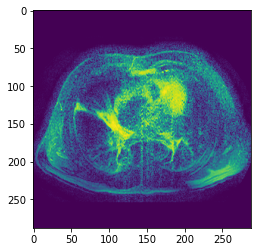

In [260]:
plt.imshow(img)

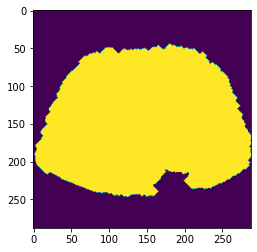

In [261]:
plt.imshow(filled_contour)

(array([1276265.,  156008.,  125122.,  109074.,  115218.,  129556.,
         157418.,  184711.,  205472.,  195364.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

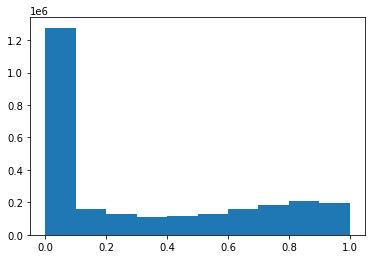

In [258]:
plt.hist(image.flatten())

In [61]:
sub="../datas/2_Domain_Adaptation_dataset/CT/16/"

src_dcm=sorted(glob(sub+f"**/*.dcm",recursive=True))
src_png=sorted(glob(sub+f"**/*.png",recursive=True))

# filter files, generate new file name
src_f=Dict(img=filt("DICOM_anon",src_dcm),msk=filt("Ground",src_png))
tmp=[m.split("/") for m in src_f.msk]
new_dir=join(*tmp[0][:-2],"NewGT")
os.makedirs(new_dir,exist_ok=True)
new_fname=[join(new_dir,t[-1]) for t in tmp] ###
# Image reading
slices = [dcmread(d) for d in src_f.img]
image=np.stack([s.pixel_array.astype("float") for s in slices])

slope = float(slices[0].RescaleSlope)
if slope != 1:
    image = (slope * image)
image[image>5000]=0.

image=image/(image[:,0,0].mean()+1e-8)
image=image/(image.max()-image.min()) ###
image=np.exp(image)/np.exp(1)
# Mask   
masks = np.stack([(cv2.imread(m)[...,0]==255) for m in src_f.msk]) ###
# for name,img,msk in zip(new_fname,image,masks):
#     # Thresholding the image
#     _, thresh = cv2.threshold((img*255).astype("uint8"), 140, 200, 0)
#     # Find Trunk Contours, and sort with contour length
#     contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours=np.squeeze(sorted(contours, key=len,reverse=True)[0])
#     # Fill contour with 1
#     filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)

#     # Find difference of trunk and liver
#     trunk=np.logical_xor(msk,filled_contour)
    
#     msk=msk*64
#     msk[trunk]=128
#     cv2.imwrite(name,msk)

In [62]:
image.max()

1.0

In [ ]:
i=5
name,img,msk=new_fname[i],image[i],masks[i]
# Thresholding the image
_, thresh = cv2.threshold((img*255).astype("uint8"), 117, 200, 0)
# Find Trunk Contours, and sort with contour length
contours_, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours=np.squeeze(np.concatenate(sorted(contours_, key=len,reverse=True)[:1]))
# Fill contour with 1
filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)
i=0
while filled_contour.sum()<np.prod(img.shape)/4:
    i+=1
    if i>2:
        print(name)
        break
    contours=np.squeeze(sorted(contours_, key=len,reverse=True)[i])
    filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)

# Find difference of trunk and liver
trunk=np.logical_xor(msk,filled_contour)

msk=msk*64
msk[trunk]=128
cv2.imwrite(name,msk)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img,"gray")
plt.subplot(1,2,2)
plt.imshow(msk,"gray")

In [67]:
contours=np.squeeze(sorted(contours_, key=len,reverse=True)[1])
# Fill contour with 1
filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)


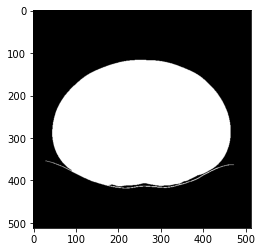

In [68]:
plt.imshow(filled_contour,"gray")